## Import Libraries

In [7]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import random
random.state= 42
np.random.seed=42
random.seed=42
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, Point
import geopandas as gpd
import xgboost as xgb
from tqdm import tqdm
import gc
from collections import defaultdict
from itertools import combinations
from pyproj import Transformer
from geopy import distance
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



## Mount Google Drive and Set Current Working Directory

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
os.chdir('/content/drive/MyDrive/EverythingDataScience/ESA_Predictions/esa-eo4soilprotection-2024-predicting-soc-density')
print(f"current working directory: {os.getcwd()}")

current working directory: /content/drive/MyDrive/EverythingDataScience/ESA_Predictions/esa-eo4soilprotection-2024-predicting-soc-density


## Read in Dataset

In [10]:
train = pd.read_csv('train_soc.csv')
test = pd.read_csv('test_soc.csv')
sub = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

In [11]:
not_needed_columns = ['olc_id', 'UUID', 'sample_id']

## Feature Engineering

### Creating Aggregation of columns

#### Obtaining the prefix of all columns name

In [12]:

all_cols = [col for col in train.columns]
cols_key_name_v1 = set([col.split('_')[0] for col in all_cols])
cols_key_name_v1 = list(cols_key_name_v1)
print(cols_key_name_v1[:20])


['nir', 'UUID', 'landform.upper.large.slope', 'evi', 'hzn', 'downslope.curvature', 'landform.hills.rough.in.small.and.large.scale', 'veg', 'red', 'slope', 'fapar', 'landform.middle.large.slope', 'green', 'swir2', 'ndsmi', 'observation', 'wetlands.regularly-flooded', 'ndmi', 'swir1', 'landform.alluvial.or.coasttal.plain.gentlest.lake.plain.playa']


In [13]:
# making sure the columns in cols_key_name_v1 are not columns that would not yield effect
cols_key_name_v2 = [col for col in cols_key_name_v1
                    if col not in not_needed_columns
                    and col !='Code' and col !='Coor' and col!='Year'
                    and col!= 'logoc_d.f' and col!='sample'
                    and col!= 'logoc']
len(cols_key_name_v2)

62

#### Calculating Aggregation

In [14]:
agg_full_train = pd.DataFrame()
agg_full_test = pd.DataFrame()

for col in tqdm(cols_key_name_v2):
    cols = [c for c in train.columns if col in c]

    train_df_agg = train[cols].agg(['mean', 'max', 'min', 'std', 'nunique', 'skew', 'kurt'], axis=1)
    test_df_agg = test[cols].agg(['mean', 'max', 'min', 'std', 'nunique', 'skew', 'kurt'], axis=1)


    train_df_agg.columns = [f'{col}_{c}' for c in train_df_agg.columns]
    test_df_agg.columns = [f'{col}_{c}' for c in test_df_agg.columns]

    agg_full_train = pd.concat([agg_full_train, train_df_agg], axis=1)
    agg_full_test = pd.concat([agg_full_test, test_df_agg], axis=1)


 48%|████▊     | 30/62 [24:17<25:50, 48.44s/it]<ipython-input-14-19d9679b06d4>:7: FutureWarning: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

#### Filtering the columns to be used in the aggregated dataset

In [14]:
agg_cols = [col for col in agg_full_train.columns if col not in agg_full_train.filter(like='X_', axis=1).columns.tolist()
            and col not in agg_full_train.filter(like='Y_', axis=1).columns.tolist()
            and col not in agg_full_train.filter(like='Unnamed', axis=1).columns.tolist()
            and col not in agg_full_train.filter(like='observation', axis=1).columns.tolist()
            and 'geo' not in col.lower()
            and 'sample' not in col.lower()
            and 'logoc' not in col.lower()
            and 'olc' not in col.lower()
            and 'UUID' not in col.lower()
            and 'Unnamed' not in col.lower()
            ]


#### Adding the aggregated columns to the main train and test dataframe

In [16]:
train = pd.concat([train, agg_full_train[agg_cols]], axis=1)
test = pd.concat([test, agg_full_test[agg_cols]], axis=1)

train.dropna(axis=1, inplace=True)
test.dropna(axis=1, inplace=True)

### Creating Aggregation of Percentile Features

In [17]:
columns_used_to_calculate_mean = []
features_list = ['clm_lst_mod11a2.nighttime_p',
                 'clm_lst_mod11a2.daytime_p',
                 'wv_mcd19a2v061.seasconv.m.yearly_p',
                 'veg_evi_mod13q1.v061_p'
                 ]

for count, feature in enumerate(features_list):
    if feature == 'wv_mcd19a2v061.seasconv.m.yearly_p':
        index = 2
    else:
        index = 3

    all_band_columns = [col for col in train.columns if feature in col.lower()]

    # get the probabiltity distribution value for each of the bands
    value_1 = int(all_band_columns[0].split('_')[index][1:])/100
    value_2 = int(all_band_columns[1].split('_')[index][1:])/100
    value_3 = int(all_band_columns[2].split('_')[index][1:])/100

    # calculate mean
    train['mean_' + feature] = ((train[all_band_columns[0]])*value_1 + (train[all_band_columns[1]])*value_2 + (train[all_band_columns[2]])*value_3)/3
    train['mean_' + feature] = train['mean_' + feature].round(2)

    test['mean_' + feature] = ((test[all_band_columns[0]])*value_1 + (test[all_band_columns[1]])*value_2 + (test[all_band_columns[2]])*value_3)/3
    test['mean_' + feature] = test['mean_' + feature].round(2)


    # append the names of the columns used to calculate the mean
    for column in all_band_columns:
        columns_used_to_calculate_mean.append(column)

### Spatial Context Features

#### Transform the coordinates from

In [20]:
############################################# Train

distance_to_north_pole = []
distance_to_south_pole = []

# tranform the coordinates from projected to geographic
transformer = Transformer.from_crs("EPSG:5070", "EPSG:4326")
geo_coords = transformer.transform(train['X'], train['Y'])

# save them to the dataframe
train['geo_X'] = geo_coords[1]
train['geo_Y'] = geo_coords[0]

# Coordinates of the North and South Pole
north_pole_coordinates = (90, 0)
south_pole_coordinates = (-90, 0)

# calculate the distance to north pole
for lat, lon in zip(train['geo_Y'], train['geo_X']):
    lat_long = (lat, lon)
    distance_cal = distance.great_circle(lat_long, north_pole_coordinates).km
    rounded_distance = round(distance_cal, 3)
    distance_to_north_pole.append(rounded_distance)
train['distance_to_north_pole'] = distance_to_north_pole

# calculate the distance to south pole
for lat, lon in zip(train['geo_Y'], train['geo_X']):
    lat_long = (lat, lon)
    distance_cal = distance.great_circle(lat_long, south_pole_coordinates).km
    rounded_distance = round(distance_cal, 3)
    distance_to_south_pole.append(rounded_distance)
train['distance_to_south_pole'] = distance_to_south_pole




############################################# Test

distance_to_north_pole = []
distance_to_south_pole = []

# tranform the coordinates from projected to geographic
transformer = Transformer.from_crs("EPSG:5070", "EPSG:4326")
geo_coords = transformer.transform(test['X'], test['Y'])

# save them to the dataframe
test['geo_X'] = geo_coords[1]
test['geo_Y'] = geo_coords[0]

# Coordinates of the North and South Pole
north_pole_coordinates = (90, 0)
south_pole_coordinates = (-90, 0)

# calculate the distance to north pole
for lat, lon in zip(test['geo_Y'], test['geo_X']):
    lat_long = (lat, lon)
    distance_cal = distance.great_circle(lat_long, north_pole_coordinates).km
    rounded_distance = round(distance_cal, 3)
    distance_to_north_pole.append(rounded_distance)
test['distance_to_north_pole'] = distance_to_north_pole

# calculate the distance to south pole
for lat, lon in zip(test['geo_Y'], test['geo_X']):
    lat_long = (lat, lon)
    distance_cal = distance.great_circle(lat_long, south_pole_coordinates).km
    rounded_distance = round(distance_cal, 3)
    distance_to_south_pole.append(rounded_distance)
test['distance_to_south_pole'] = distance_to_south_pole

#### Depth Percentage

In [21]:
############################################# Train
train['upper_depth_percent'] = (train['hzn_top'] / 1564) * 100
train['lower_depth_percent'] = (train['hzn_bot'] / 1628) * 100

############################################# Test
test['upper_depth_percent'] = (test['hzn_top'] / 1564) * 100
test['lower_depth_percent'] = (test['hzn_bot'] / 1628) * 100

#### Depth Ratio

In [22]:
############################################# Train
train['depth_ratio_upper_lower'] = train['hzn_top'] / train['hzn_bot']

############################################# Test
test['depth_ratio_upper_lower'] = test['hzn_top'] / test['hzn_bot']

#### Depth Difference

In [23]:
############################################# Train
train['depth_difference'] = train['hzn_bot'] - train['hzn_top']

############################################# Test
test['depth_difference'] = test['hzn_bot'] - test['hzn_top']

#### Classifying depths into sub layers e.g top soil, sub-soil

In [31]:
############################################# Train
depth_layers = []

for top_depth, bottom_depth in zip(train['hzn_top'], train['hzn_bot']):
    if top_depth >=0 and bottom_depth <=30:
        depth_layers.append('top_soil')
    elif top_depth >=30 and bottom_depth <=100:
        depth_layers.append('upper_sub_soil')
    elif top_depth >=50 and bottom_depth <=100:
        depth_layers.append('mid_sub_soil')
    elif top_depth >=100 and bottom_depth <=180:
        depth_layers.append('deeper_sub_soil')
    else:
        depth_layers.append('least_layer')

train['depth_classes'] = depth_layers


############################################# Test
depth_layers = []

for top_depth, bottom_depth in zip(test['hzn_top'], test['hzn_bot']):
    if top_depth >=0 and bottom_depth <=30:
        depth_layers.append('top_soil')
    elif top_depth >=30 and bottom_depth <=100:
        depth_layers.append('upper_sub_soil')
    elif top_depth >=50 and bottom_depth <=100:
        depth_layers.append('mid_sub_soil')
    elif top_depth >=100 and bottom_depth <=180:
        depth_layers.append('deeper_sub_soil')
    else:
        depth_layers.append('least_layer')

test['depth_classes'] = depth_layers


##### Hot encoding Depth Classes

In [32]:
# hot one encode the classses
train = pd.get_dummies(train, columns = ['depth_classes'])
test = pd.get_dummies(test, columns = ['depth_classes'])

### Defining Columns to Use

In [1]:
training_features = ['dtm_lithology_usgs.ecotapestry.undefined_p_250m_s0..0cm_2014_v1.0',
                    'swir2_mean', 'hzn_mean','wetlands.cw_max','wetlands.cw_mean','clm_max',
 'snow.prob_esacci.m12_p90_500m_s_2000_2012_go_epsg.4326_v20231002','clm_lst_mod11a2.daytime_p95_1km_s0..0cm__v1.2',
 'wetlands.cw_upmc.wtd_c_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002','wetlands.cw_min',
 'mean_clm_lst_mod11a2.daytime_p','bioclim.var_std','red_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908','geo_Y',
 'distance_to_south_pole','distance_to_north_pole','bioclim.var_mean','geo_X','green_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'snow.prob_esacci.m07_p90_500m_s_2000_2012_go_epsg.4326_v20231002','hzn_max','bioclim.var_max','lower_depth_percent',
 'snow.prob_esacci.m07_sd_500m_s_2000_2012_go_epsg.4326_v20231002','bsf_max','upper_depth_percent','vbf_min','bsf_min','vbf_max',
 'dtm_lithology_usgs.ecotapestry.intermediate.volcanics_p_250m_s0..0cm_2014_v1.0','snow.prob_mean','landform.steep.mountain.rough_mean',
 'landform.alluvial.or.coasttal.plain.gentlest.lake.plain.playa_mean', 'clm_std','clm_min','bioclim.var_kurt','bioclim.var_chelsa.bio16_m_1km_s_1981_2010_go_epsg.4326_v20231002',
 'bioclim.var_chelsa.bio3_m_1km_s_1981_2010_go_epsg.4326_v20231002','vbf_mean','swir2_max','hzn_min','vbf_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002',
 'snow.prob_std','nir_min','bsf_mean','swir1_mean','bioclim.var_skew','hzn_bot', 'snow.prob_esacci.m01_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'dtm_lithology_usgs.ecotapestry.acid.plutonics_p_250m_s0..0cm_2014_v1.0','clm_lst_mod11a2.nighttime_sd_1km_s0..0cm__v1.2','bioclim.var_min',
 'mean_wv_mcd19a2v061.seasconv.m.yearly_p','thermal_mean','wv_min','red_max','landform.steep.mountain.rough_min','wetlands.permanent_max',
 'wetlands.permanent_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002','clm_skew',
 'snow.prob_max','wv_mcd19a2v061.seasconv.m.yearly_p25_1km_s_0101_1231_go_epsg.4326_v20230619','thermal_min',
 'mean_clm_lst_mod11a2.nighttime_p','landform.steep.mountain.rough_max','landform_skew','green_min','swir2_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'snow.prob_esacci.m04_p90_500m_s_2000_2012_go_epsg.4326_v20231002','hzn_top','wetlands.permanent_min','wetlands.permanent_mean',
 'clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm__v2.1','veg_evi_mod13q1.v061_p05_250m_s0..0cm__v1.0','wv_max',
 'landform.moderate.mountain.smooth_mean','veg_mean','wv_mcd19a2v061.seasconv.m.yearly_sd_1km_s_0101_1231_go_epsg.4326_v20230619',
 'swir2_min','wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_0101_1231_go_epsg.4326_v20230619',
 'slope_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002','swir2_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908','wv_mean',
 'mean_veg_evi_mod13q1.v061_p','snow.prob_esacci.m11_sd_500m_s_2000_2012_go_epsg.4326_v20231002','blue_min','snow.prob_esacci.m06_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'thermal_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908','wv_mcd19a2v061.seasconv.m.yearly_p75_1km_s_0101_1231_go_epsg.4326_v20230619',
 'nir_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908','bioclim.var_chelsa.bio13_m_1km_s_1981_2010_go_epsg.4326_v20231002',
 'red_min','swir2_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908','nir_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908','landform_kurt',
 'dtm_lithology_usgs.ecotapestry.acid.volcanic_p_250m_s0..0cm_2014_v1.0','wv_std','clm_lst_mod11a2.nighttime_p95_1km_s0..0cm__v1.2',
 'landform.moderate.mountain.smooth_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002','clm_lst_mod11a2.daytime_p50_1km_s0..0cm__v1.2',
 'green_max','landform.steep.mountain.rough_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
 'landform.moderate.mountain.smooth_max','slope_min','dtm_mean','wetlands.regularly-flooded_max',
 'bioclim.var_chelsa.bio2_m_1km_s_1981_2010_go_epsg.4326_v20231002','landform_mean',
 'swir1_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908','veg_std','evi_kurt','wetlands.regularly-flooded_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002',
 'snow.prob_esacci.m03_p90_500m_s_2000_2012_go_epsg.4326_v20231002','clm_mean','wetlands.groundwater-driven_min','snow.prob_esacci.m02_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'snow.prob_esacci.m05_p90_500m_s_2000_2012_go_epsg.4326_v20231002','evi_skew','landform.middle.large.slope_max','evi_max',
 'dtm_std','evi_mean','log1p.upstream.area_min','lcv.forest_max',
 'downslope.curvature_mean','log1p.upstream.area_max','snow.prob_esacci.m06_sd_500m_s_2000_2012_go_epsg.4326_v20231002','wetlands.regularly-flooded_min',
 'red_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908','dtm_skew','wetlands.regularly-flooded_mean',
 'clm_kurt','red_mean','clm_lst_mod11a2.nighttime_p05_1km_s0..0cm__v1.2',
 'landform.alluvial.or.coasttal.plain.gentlest.lake.plain.playa_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
 'snow.prob_esacci.m05_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'dtm_lithology_usgs.ecotapestry.unconsolidated.sediment_p_250m_s0..0cm_2014_v1.0',
 'red_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908','swir1_max','lcv.forest_hilda_dv1_1km_s0..0cm__v0.1','snow.prob_skew','green_mean',
 'veg_evi_mod13q1.v061_p50_250m_s0..0cm__v1.0','log1p.upstream.area_mean','slope_std',
 'landform.alluvial.or.coasttal.plain.gentlest.lake.plain.playa_max',
 'snow.prob_esacci.m10_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'log1p.upstream.area_merit.hydro_m_250m_b0..0cm_2017_2017_go_epsg.4326_v20231002','wv_skew','nir_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908','veg_max',
 'lcv_std','wetlands.groundwater-driven_max','thermal_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908','depth_classes_top_soil','blue_max','veg_evi_mod13q1.v061_p95_250m_s0..0cm__v1.0',
 'swir1_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908',
 'wetlands.groundwater-driven_upmc.wtd_p_250m_b0..200cm_2010_2015_go_epsg.4326_v20231002','landform_terrain.class_c_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002','ndmi_mean',
 'lcv.forest_min','landform.alluvial.plain.pediplain_mean','snow.prob_esacci.m09_sd_500m_s_2000_2012_go_epsg.4326_v20231002','dtm_kurt','snow.prob_kurt',
 'dtm_lithology_usgs.ecotapestry_c_250m_s0..0cm_2014_v1.0','landform.moderate.mountain.smooth_min','snow.prob_esacci.m10_sd_500m_s_2000_2012_go_epsg.4326_v20231002','veg_skew','thermal_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'swir2_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908','snow.prob_esacci.m03_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'landform.alluvial.plain.pediplain_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002',
 'green_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908', 'landform.hills.rough.in.small.and.large.scale_max',
 'swir2_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908','thermal_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908','blue_mean',
 'snow.prob_esacci.m09_p90_500m_s_2000_2012_go_epsg.4326_v20231002','veg_min','nir_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'upslope.curvature_mean','upslope.curvature_max','lcv_max','pos.openess_mean','wetlands.groundwater-driven_mean','snow.prob_esacci.m04_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'red_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908','thermal_glad.SeasConv.ard2_m_30m_s_0901_1031_go_epsg.4326_v20230908',
 'landform.middle.large.slope_terrain.class_p_250m_s0..0cm_2017_2018_go_epsg.4326_v20231002','clm_lst_mod11a2.daytime_sd_1km_s0..0cm__v1.2',
 'swir1_min','evi_std','swir2_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'downslope.curvature_max','landform.slope.in.and.around.terrace.or.plateau_min',
 'nightlights.average_min','landform.alluvial.plain.pediplain_max',
 'red_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908','wv_kurt','bioclim.var_chelsa.bio12_m_1km_s_1981_2010_go_epsg.4326_v20231002',
 'snow.prob_esacci.m11_p90_500m_s_2000_2012_go_epsg.4326_v20231002','veg_evi_mod13q1.v061_sd_250m_s0..0cm__v1.0',
 'pos.openess_max','pos.openess_min','lcv_mean','ndmi_min','clm_lst_mod11a2.daytime_p05_1km_s0..0cm__v1.2',
 'nightlights.average_mean','nightlights.average_viirs.v21_m_500m_s_0101_1231_go_epsg4326_v20230318',
 'green_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908','lcv.forest_mean',
 'pos.openess_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002',
 'downslope.curvature_min','ndsmi_min','red_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908',
 'upslope.curvature_merit.dem_m_250m_s0..0cm_2017_2017_go_epsg.4326_v20231002','evi_min','slope_max',
 'nightlights.average_max','snow.prob_esacci.m02_sd_500m_s_2000_2012_go_epsg.4326_v20231002','snow.prob_esacci.m12_sd_500m_s_2000_2012_go_epsg.4326_v20231002',
 'thermal_glad.SeasConv.ard2_m_30m_s_0101_0228_go_epsg.4326_v20230908',
 'slope_mean','landform_std','green_glad.SeasConv.ard2_m_30m_s_0701_0831_go_epsg.4326_v20230908',
 'snow.prob_esacci.m08_p90_500m_s_2000_2012_go_epsg.4326_v20231002',
 'landform.terrace.smooth.plateau_min','landform.slope.in.and.around.terrace.or.plateau_max',
 'swir1_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908','ndmi_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'lcv_min','landform.hills.rough.in.small.and.large.scale_std',
 'thermal_std','lcv_globalcropland_bowen.et.al_p_1km_s0..0cm__v0.1',
 'ndwi_min','Y','landform.alluvial.or.coasttal.plain.gentlest.lake.plain.playa_min','ndwi_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'clm_lst_mod11a2.nighttime_p50_1km_s0..0cm__v1.2',
 'ndsmi_glad.SeasConv.ard2_m_30m_s_0501_0630_go_epsg.4326_v20230908',
 'red_std','green_glad.SeasConv.ard2_m_30m_s_0301_0430_go_epsg.4326_v20230908','nir_glad.SeasConv.ard2_m_30m_s_1101_1231_go_epsg.4326_v20230908',
 'dtm_lithology_usgs.ecotapestry.mixed.sedimentary.rock_p_250m_s0..0cm_2014_v1.0','savi_mean',
 'depth_classes_upper_sub_soil','ndti_max','upslope.curvature_min']

In [58]:
train = train.loc[:, ~train.columns.duplicated()]
test = test.loc[:, ~test.columns.duplicated()]


### Modelling

In [61]:
X, y  = train[training_features], train['logoc_d.f']

kf = KFold(n_splits =5,shuffle=True,random_state=160)
feats = pd.DataFrame({'features': X.columns})
gbm_predictions = []
cv_score_ = 0
oof_preds = np.zeros((train.shape[0],))


for i,(tr_index,test_index) in enumerate(kf.split(X,y)):

    print()
    print(f'######### FOLD {i+1} / {kf.n_splits} ')

    X_train,y_train = X.iloc[tr_index,:],y[tr_index]
    X_test,y_test = X.iloc[test_index,:],y[test_index]


    gbm = xgb.XGBRegressor(
                            eval_metric = 'rmse',
                            n_estimators=20000,
                                max_depth=7,
                                learning_rate=0.01,
                                subsample=0.8,
                                colsample_bytree=0.4,
                                missing=-1,
                                    early_stopping_rounds= 200,
                             device='cuda'
                             )
    gbm.fit(X_train,y_train,eval_set = [(X_test, y_test)],verbose=1000)


    cv_score_ += mean_squared_error(y_test, gbm.predict(X_test), squared=False) / kf.n_splits
    oof_preds[test_index] = gbm.predict(X_test)

    preds = gbm.predict(test[X_train.columns])
    gbm_predictions.append(preds)

    feats[f'Fold {i}'] = gbm.feature_importances_

feats['Importances'] = feats.mean(axis=1)
preds_xgb = np.average(gbm_predictions, axis=0)
print( ' CV RMSE : ',cv_score_)



######### FOLD 1 / 5 
[0]	validation_0-rmse:1.01731
[1000]	validation_0-rmse:0.53293
[2000]	validation_0-rmse:0.50078
[3000]	validation_0-rmse:0.48691
[4000]	validation_0-rmse:0.48094
[5000]	validation_0-rmse:0.47795
[6000]	validation_0-rmse:0.47660
[7000]	validation_0-rmse:0.47581
[8000]	validation_0-rmse:0.47543
[8363]	validation_0-rmse:0.47540

######### FOLD 2 / 5 
[0]	validation_0-rmse:1.02843
[1000]	validation_0-rmse:0.51988
[2000]	validation_0-rmse:0.48918
[3000]	validation_0-rmse:0.47639
[4000]	validation_0-rmse:0.46986
[5000]	validation_0-rmse:0.46697
[6000]	validation_0-rmse:0.46527
[7000]	validation_0-rmse:0.46416
[8000]	validation_0-rmse:0.46374
[9000]	validation_0-rmse:0.46350
[9044]	validation_0-rmse:0.46347

######### FOLD 3 / 5 
[0]	validation_0-rmse:1.01529
[1000]	validation_0-rmse:0.53062
[2000]	validation_0-rmse:0.49643
[3000]	validation_0-rmse:0.48298
[4000]	validation_0-rmse:0.47659
[5000]	validation_0-rmse:0.47293
[6000]	validation_0-rmse:0.47084
[7000]	validatio

<ipython-input-61-91bcb6fcceaf>:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feats['Importances'] = feats.mean(axis=1)


### Making Submission

In [ ]:
test['logoc_d.f'] = preds_xgb

test[['sample_id', 'logoc_d.f']].to_csv('xgb_second_sub_250_feats.csv', index=False)

### Feature Importance

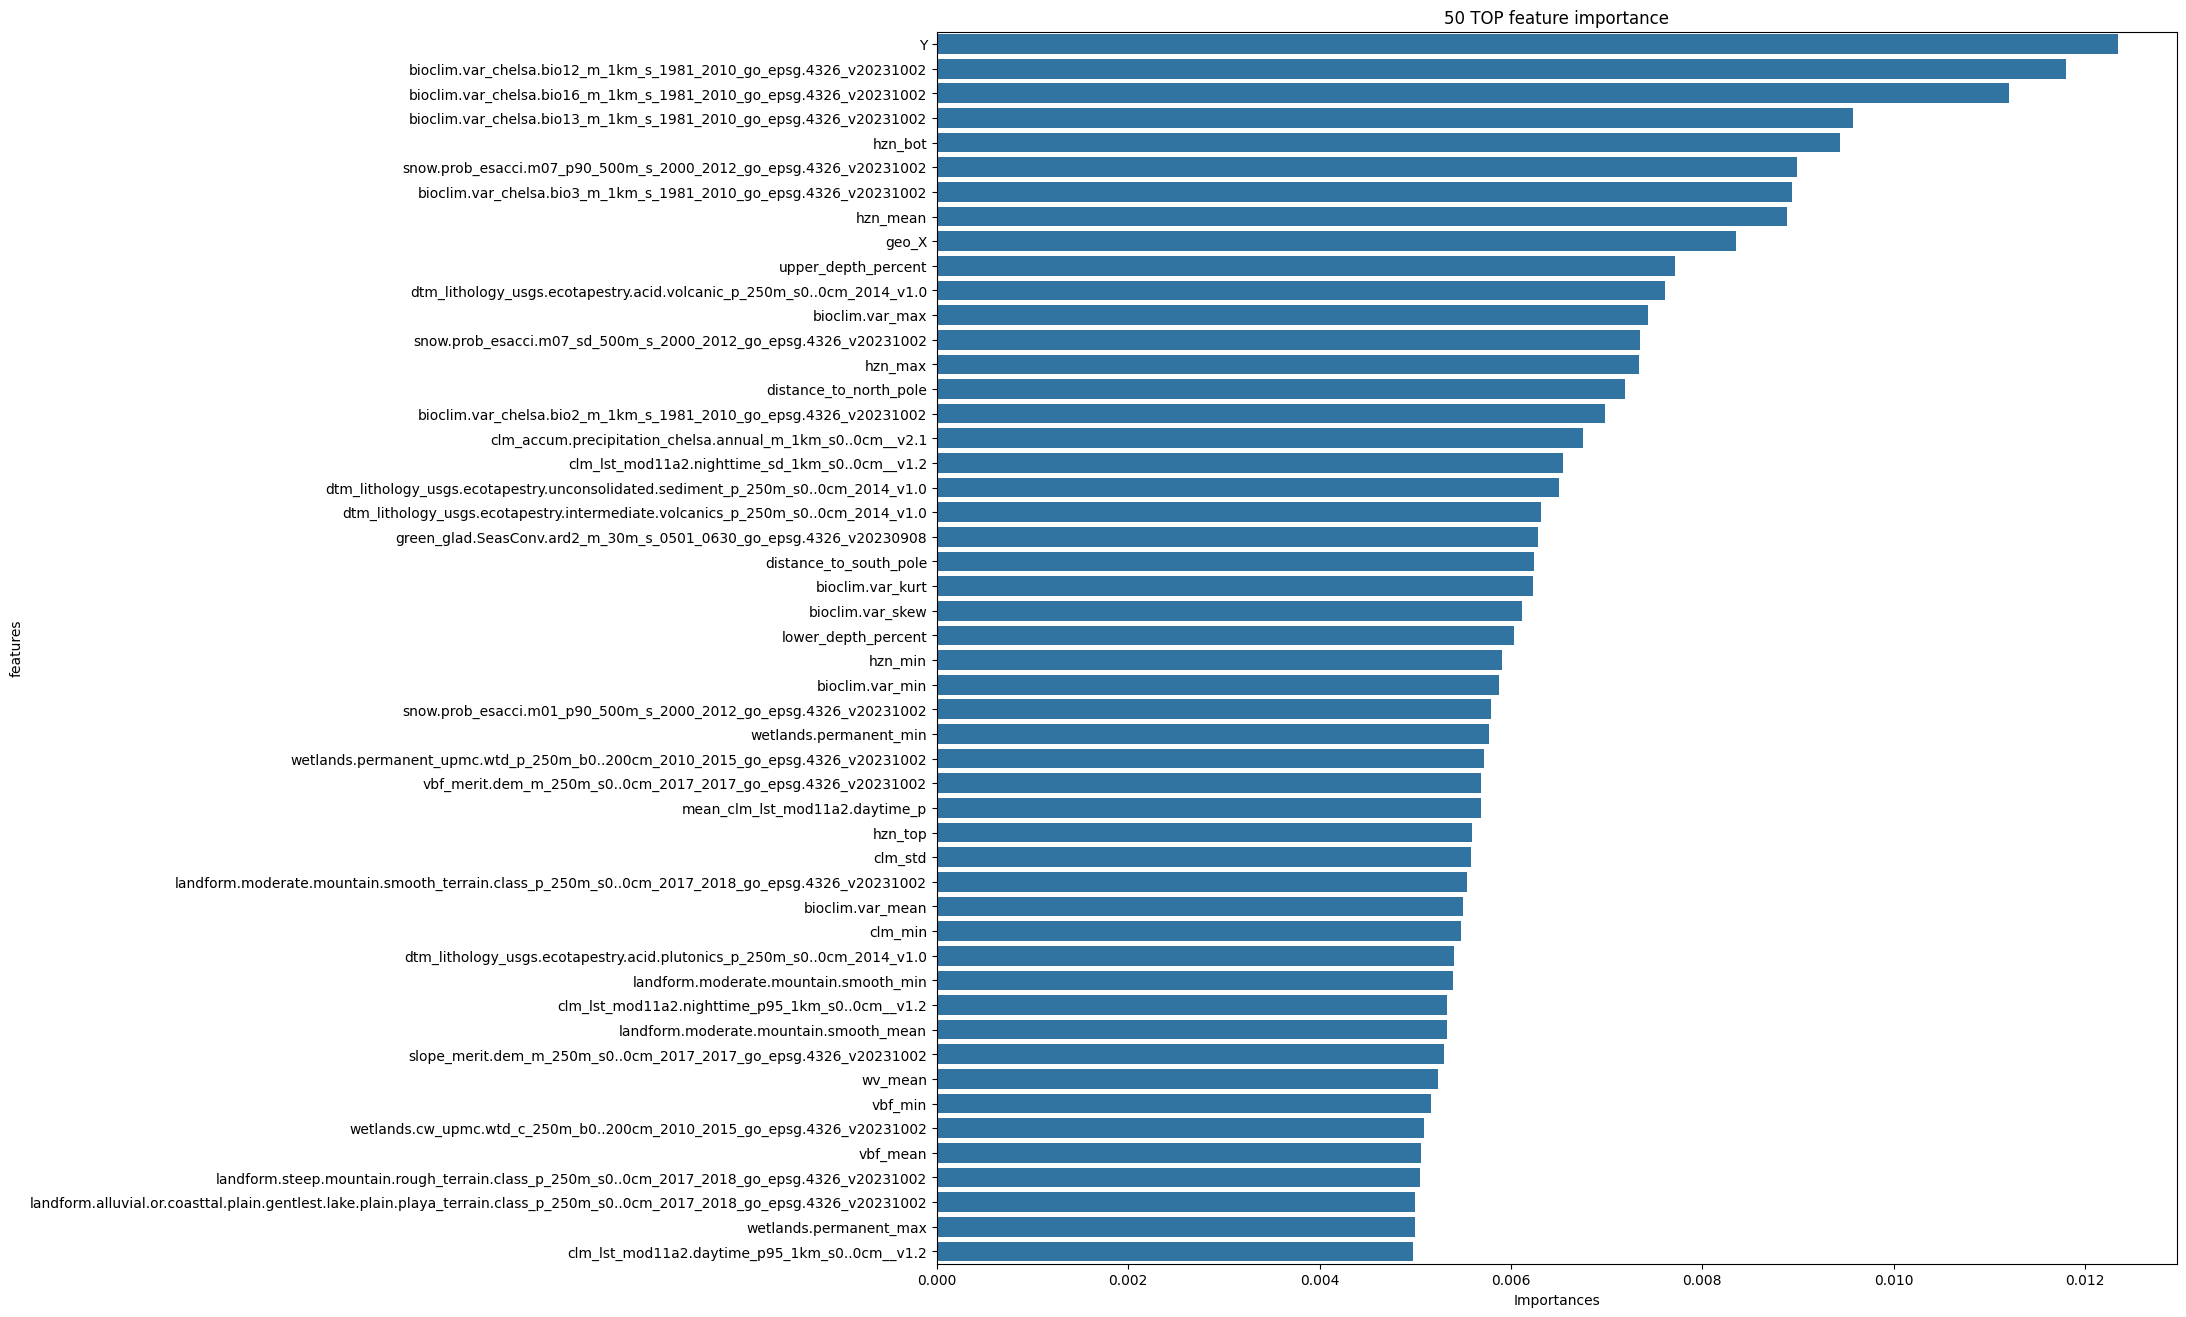

In [42]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feats.sort_values(by='Importances', ascending=False).head(50), x='Importances', y='features');
plt.title('50 TOP feature importance');
